In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import plot_reconstruction

### a) Loading the dataset

In [2]:
#function to dispay a digit image
def show_img(v):
    v = v.reshape((-1,28))
    assert v.shape == (28, 28)
    plt.imshow(v, cmap='gray')

In [3]:
#loading the dataset as a dataframe
mnist_df = pd.read_csv('X_train.csv', delimiter=',', header=None)
mnist_df

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,255,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,0,0,0,0,0,0,0,0,0,0,...,255,0,0,0,0,0,0,0,0,0
3596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#making np.array from the dataset, and setting the values to [0,1] segment
mnist_orig = mnist_df.values/255.
mnist_orig.shape

(3600, 784)

In [5]:
#taking the last example and displaying it
last_ex = mnist_orig[-1]
last_ex.shape

(784,)

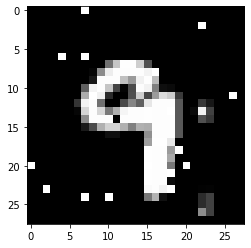

In [6]:
show_img(last_ex)

### b) Implementing PCA using SVM

In [7]:
#mean-centering the data
mnist_mean = np.mean(mnist_orig, axis=0)
mnist_mean.shape

(784,)

In [8]:
mnist = mnist_orig - mnist_mean
mnist.shape

(3600, 784)

In [9]:
#implementing the SVM
U, Sigma, Vt = np.linalg.svd(mnist, full_matrices=False)

In [10]:
U.shape, Sigma.shape, Vt.shape

((3600, 784), (784,), (784, 784))

In [11]:
#three highest singular values
Sigma[:3]

array([145.44214904, 127.60264947, 112.95887   ])

In [12]:
#taking the first four PCs
pc = Vt[:4]
pc.shape, pc[0].shape

((4, 784), (784,))

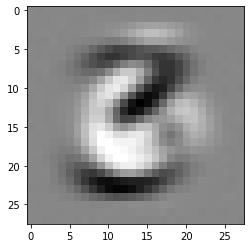

In [13]:
#the image of the 1st (and the next fews) PCs 
show_img(pc[0])

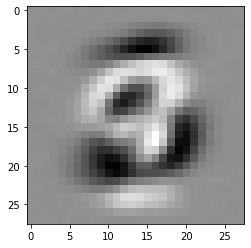

In [14]:
show_img(pc[1])

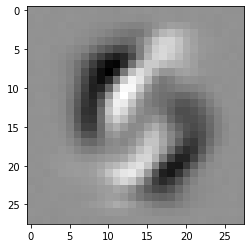

In [15]:
show_img(pc[2])

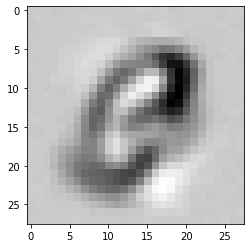

In [16]:
show_img(pc[3])

Observing the 1st PC, we see that the majority of black pixels will be distributed in the white pixels area of the 1st PC image. The pixels belonging to the numbers (the wite pixels in images) are centered in the black/gray area of the 1st PC image, which makes up a kind of union of "3", "6" and "9" ciphers. 

### c) Projecting in PC dimensions

In [17]:
#taking the first two PCs and projecting along the corresponding spanning subspace
pc = Vt[:2]
pc_scores = mnist @ pc.T
pc_scores.shape

(3600, 2)

Text(0, 0.5, 'PC2 scores')

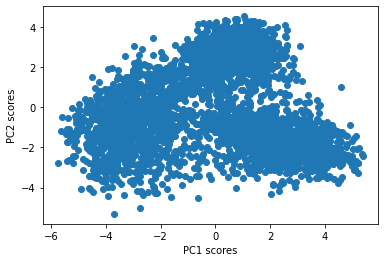

In [18]:
fig, ax = plt.subplots()
plt.scatter(x=pc_scores[:,0], y=pc_scores[:,1])
ax.set_xlabel('PC1 scores')
ax.set_ylabel('PC2 scores')

In [ ]:
#projecting along the spanning subspace of 100th and 101st PC
pc = Vt[[99, 100]]
pc_scores = mnist @ pc.T
pc_scores.shape

In [ ]:
fig, ax = plt.subplots()
plt.scatter(x=pc_scores[:,0], y=pc_scores[:,1])
ax.set_xlabel('PC100 scores')
ax.set_ylabel('PC101 scores')

As in the first part, we can se that the first scatterplot is clustered around three centers, which (should) correspond to the three ciphers - '3','6' and '9'. The second scatterplot is less informative: it just tells us that the points of interest are going to be gathered around in the center of the image.

### d) Reconstruction accuracy

In [19]:
eigenvals = Sigma
eigenvals.shape

(784,)

In [20]:
#ploting the rec. acc. graph for differen number of PCs included
eigen_sum = np.sum(eigenvals)
part_eigen_sum = 0
rec_acc = []
for k in eigenvals:
    part_eigen_sum += k/eigen_sum
    rec_acc.append(part_eigen_sum)

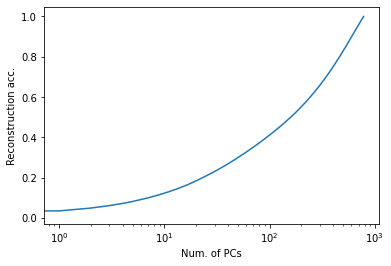

In [21]:
fig, ax = plt.subplots()
plt.plot(rec_acc)
ax.set_xlabel('Num. of PCs')
ax.set_ylabel('Reconstruction acc.')
ax.set_xscale('log')

In [22]:
#making the reconstruction table
rec_acc = 0
k = 0
num_pc = []
for x in np.arange(.1, 1, .1):
    while rec_acc <= x:
        rec_acc += (eigenvals[k]/eigen_sum)
        k +=1
    num_pc.append(k)
num_pc

[9, 25, 52, 95, 160, 245, 346, 464, 604]

In [23]:
d = {'Rec. acc. %': np.arange(10, 91, 10), 'Num. of PCs': num_pc}
rec_acc_table = pd.DataFrame(d, index=None)
rec_acc_table

,Rec. acc. %,Num. of PCs
0,10,9
1,20,25
2,30,52
3,40,95
4,50,160
5,60,245
6,70,346
7,80,464
8,90,604


### e) Reconstructing various examples, for various percents

In [24]:
def reconstruct(idx, k):
    x_rc = np.zeros(784)
    for j in range(k):
        x_rc = x_rc + (mnist[idx]@Vt[j])*Vt[j]
    x_rc = x_rc + mnist_mean
    return x_rc

In [25]:
def reconstruct_all(idx):
    x_all_rec = []
    for k in num_pc:
        x_rec = reconstruct(idx, k)
        x_all_rec.append(x_rec)

    x_all_rec.append(mnist_orig[idx])
    x_all_rec = np.array(x_all_rec)
    x_all_rec = x_all_rec.reshape((-1, 28, 28))
    plot_reconstruction(images=x_all_rec, title=f'Example {idx+1}', filename=f'ex_{idx+1}.png')

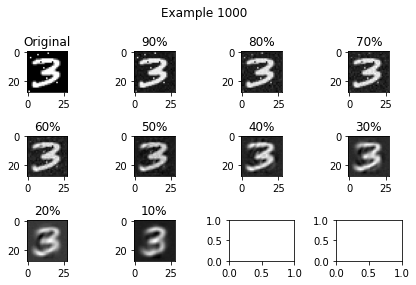

In [26]:
reconstruct_all(999)

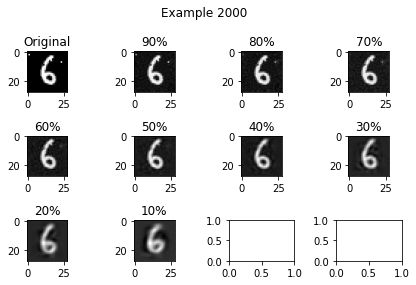

In [27]:
reconstruct_all(1999)

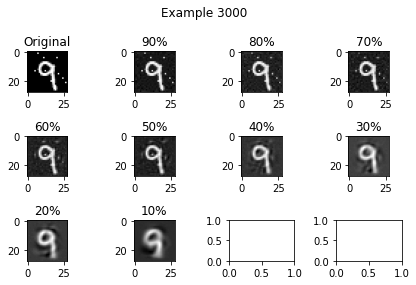

In [28]:
reconstruct_all(2999)